COMPLETE PREPROCESSING PIPELINE WITH FEATURE SELECTION

[STEP 1] Loading dataset...
Loaded: 1000 rows × 17 columns
Missing values: 757

[STEP 2] Separating features and target...
Features: 16 columns
Target distribution:
Health_Score
1    181
2    229
3    172
4    205
5    213
Name: count, dtype: int64

[STEP 3] Feature types:
  Numeric: 9
  Categorical: 7

[STEP 4] Building preprocessing pipeline...
  ✓ Pipeline created

[STEP 5] Splitting data with stratification...
  Training: 700 samples
  Testing: 300 samples

[STEP 6] Applying preprocessing...
  Features after encoding: 58
  Samples per feature: 12.1:1

[STEP 7] Performing feature selection...
  Selected: 25 most important features
  New samples per feature: 28.0:1

  Top 10 features:
    4. Watering_Amount_ml                       (importance: 0.0746)
    6. Room_Temperature_C                       (importance: 0.0693)
    9. Soil_Moisture_%                          (importance: 0.0683)
    1. Height_cm                         

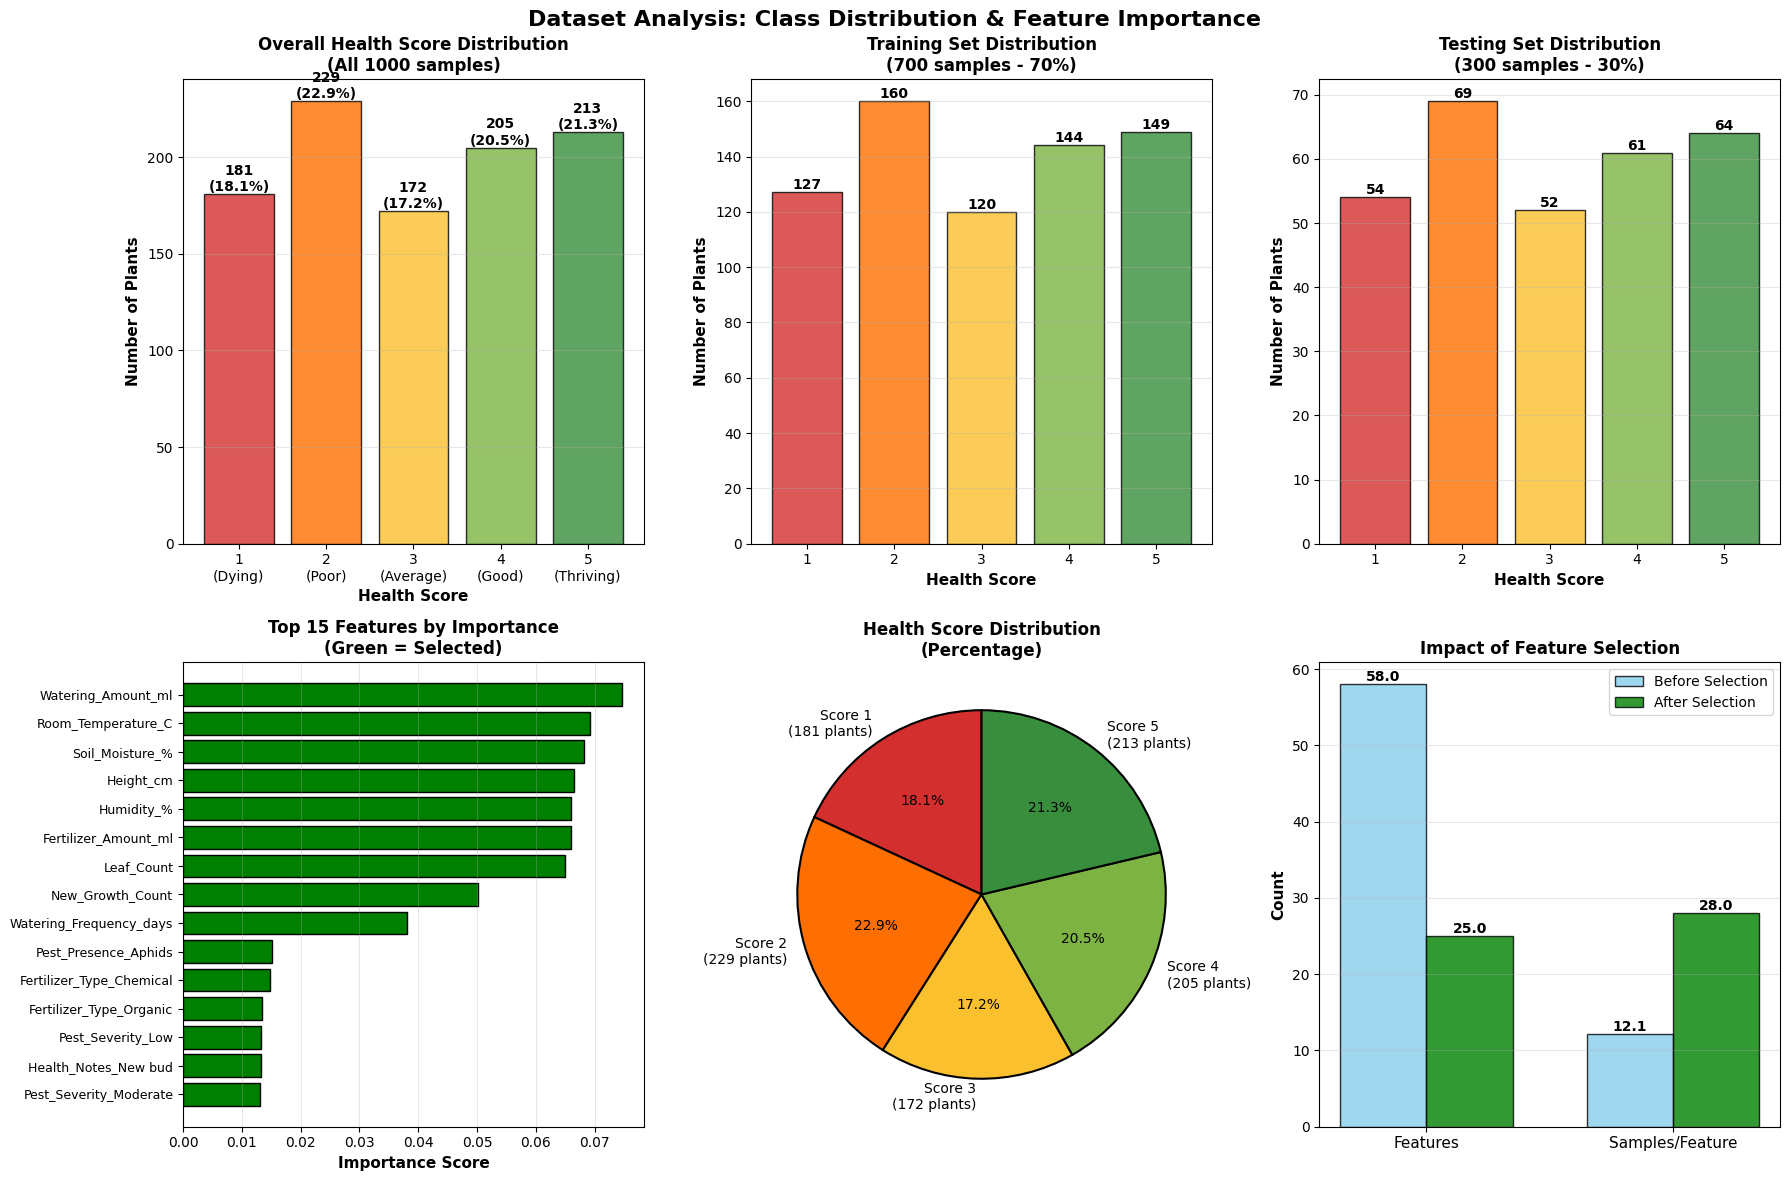


[STEP 9] Class Distribution Statistics...

CLASS DISTRIBUTION ANALYSIS

Overall Dataset:
  Health Score 1:  181 samples ( 18.1%)
  Health Score 2:  229 samples ( 22.9%)
  Health Score 3:  172 samples ( 17.2%)
  Health Score 4:  205 samples ( 20.5%)
  Health Score 5:  213 samples ( 21.3%)

Training Set (700 samples):
  Health Score 1:  127 samples ( 18.1%)
  Health Score 2:  160 samples ( 22.9%)
  Health Score 3:  120 samples ( 17.1%)
  Health Score 4:  144 samples ( 20.6%)
  Health Score 5:  149 samples ( 21.3%)

Testing Set (300 samples):
  Health Score 1:   54 samples ( 18.0%)
  Health Score 2:   69 samples ( 23.0%)
  Health Score 3:   52 samples ( 17.3%)
  Health Score 4:   61 samples ( 20.3%)
  Health Score 5:   64 samples ( 21.3%)


[STEP 10] Saving preprocessed datasets...

  ✓ training_preprocessed_plant_data(2).csv
    - 700 rows × 26 columns

  ✓ testing_preprocessed_plant_data(2).csv
    - 300 rows × 26 columns

  ✓ complete_preprocessed_plant_data(2).csv
    - 1000 rows × 2

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import issparse

print("=" * 70)
print("COMPLETE PREPROCESSING PIPELINE WITH FEATURE SELECTION")
print("=" * 70)

# --------------------
# STEP 1: Load Dataset
# --------------------
print("\n[STEP 1] Loading dataset...")
df = pd.read_csv("Indoor_Plant_Health_and_Growth_Factors.csv")
print(f"Loaded: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"Missing values: {df.isnull().sum().sum()}")

# --------------------
# STEP 2: Separate Features and Target
# --------------------
print("\n[STEP 2] Separating features and target...")
y = df['Health_Score']
X = df.drop(columns=['Health_Score'])
print(f"Features: {X.shape[1]} columns")
print(f"Target distribution:\n{y.value_counts().sort_index()}")

# --------------------
# STEP 3: Define Feature Types
# --------------------
numeric_features = ['Height_cm', 'Leaf_Count', 'New_Growth_Count',
                    'Watering_Amount_ml', 'Watering_Frequency_days',
                    'Room_Temperature_C', 'Humidity_%',
                    'Fertilizer_Amount_ml', 'Soil_Moisture_%']

categorical_features = ['Plant_ID', 'Health_Notes', 'Sunlight_Exposure',
                        'Fertilizer_Type', 'Pest_Presence', 'Pest_Severity',
                        'Soil_Type']

print(f"\n[STEP 3] Feature types:")
print(f"  Numeric: {len(numeric_features)}")
print(f"  Categorical: {len(categorical_features)}")

# --------------------
# STEP 4: Build Preprocessing Pipeline
# --------------------
print("\n[STEP 4] Building preprocessing pipeline...")

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ])

print("  ✓ Pipeline created")

# --------------------
# STEP 5: Split Data (70/30 Stratified)
# --------------------
print("\n[STEP 5] Splitting data with stratification...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"  Training: {X_train.shape[0]} samples")
print(f"  Testing: {X_test.shape[0]} samples")

# --------------------
# STEP 6: Apply Preprocessing
# --------------------
print("\n[STEP 6] Applying preprocessing...")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get feature names
feature_names = list(numeric_features)
cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
feature_names.extend(cat_feature_names)

print(f"  Features after encoding: {len(feature_names)}")
print(f"  Samples per feature: {X_train.shape[0] / len(feature_names):.1f}:1")

# Convert sparse to dense
if issparse(X_train_processed):
    X_train_dense = X_train_processed.toarray()
    X_test_dense = X_test_processed.toarray()
else:
    X_train_dense = X_train_processed
    X_test_dense = X_test_processed

# --------------------
# STEP 7: Feature Selection
# --------------------
print("\n[STEP 7] Performing feature selection...")

# Use Random Forest for feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_dense, y_train)

# Get feature importances
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# Select top 25 features
k_features = 25
top_features = feature_importance_df.head(k_features)['feature'].tolist()
top_indices = [feature_names.index(f) for f in top_features]

# Apply feature selection
X_train_selected = X_train_dense[:, top_indices]
X_test_selected = X_test_dense[:, top_indices]

print(f"  Selected: {k_features} most important features")
print(f"  New samples per feature: {X_train_selected.shape[0] / k_features:.1f}:1")
print(f"\n  Top 10 features:")
for i, row in feature_importance_df.head(10).iterrows():
    print(f"    {i+1}. {row['feature'][:40]:40s} (importance: {row['importance']:.4f})")

# --------------------
# STEP 8: Visualize Class Distribution
# --------------------
print("\n[STEP 8] Creating class distribution visualizations...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Dataset Analysis: Class Distribution & Feature Importance', fontsize=16, fontweight='bold')

# Plot 1: Overall class distribution
ax1 = axes[0, 0]
class_counts = y.value_counts().sort_index()
colors_health = ['#d32f2f', '#ff6f00', '#fbc02d', '#7cb342', '#388e3c']
bars = ax1.bar(class_counts.index, class_counts.values, color=colors_health, alpha=0.8, edgecolor='black')
ax1.set_xlabel('Health Score', fontsize=11, fontweight='bold')
ax1.set_ylabel('Number of Plants', fontsize=11, fontweight='bold')
ax1.set_title('Overall Health Score Distribution\n(All 1000 samples)', fontsize=12, fontweight='bold')
ax1.set_xticks([1, 2, 3, 4, 5])
ax1.set_xticklabels(['1\n(Dying)', '2\n(Poor)', '3\n(Average)', '4\n(Good)', '5\n(Thriving)'])
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}\n({height/len(y)*100:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 2: Training set class distribution
ax2 = axes[0, 1]
train_counts = y_train.value_counts().sort_index()
bars2 = ax2.bar(train_counts.index, train_counts.values, color=colors_health, alpha=0.8, edgecolor='black')
ax2.set_xlabel('Health Score', fontsize=11, fontweight='bold')
ax2.set_ylabel('Number of Plants', fontsize=11, fontweight='bold')
ax2.set_title('Training Set Distribution\n(700 samples - 70%)', fontsize=12, fontweight='bold')
ax2.set_xticks([1, 2, 3, 4, 5])
ax2.grid(axis='y', alpha=0.3)

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 3: Testing set class distribution
ax3 = axes[0, 2]
test_counts = y_test.value_counts().sort_index()
bars3 = ax3.bar(test_counts.index, test_counts.values, color=colors_health, alpha=0.8, edgecolor='black')
ax3.set_xlabel('Health Score', fontsize=11, fontweight='bold')
ax3.set_ylabel('Number of Plants', fontsize=11, fontweight='bold')
ax3.set_title('Testing Set Distribution\n(300 samples - 30%)', fontsize=12, fontweight='bold')
ax3.set_xticks([1, 2, 3, 4, 5])
ax3.grid(axis='y', alpha=0.3)

for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 4: Feature Importance
ax4 = axes[1, 0]

# Plot 4: Feature Importance
ax4 = axes[1, 0]
top_15 = feature_importance_df.head(15)
colors_imp = ['green' if i < k_features else 'lightgray' for i in range(len(top_15))]
ax4.barh(range(len(top_15)), top_15['importance'].values, color=colors_imp, edgecolor='black')
ax4.set_yticks(range(len(top_15)))
ax4.set_yticklabels([f[:30] for f in top_15['feature'].values], fontsize=9)
ax4.set_xlabel('Importance Score', fontsize=11, fontweight='bold')
ax4.set_title('Top 15 Features by Importance\n(Green = Selected)', fontsize=12, fontweight='bold')
ax4.invert_yaxis()
ax4.grid(axis='x', alpha=0.3)

# Plot 5: Pie chart - Overall distribution percentages
ax5 = axes[1, 1]
ax5.pie(class_counts.values, labels=[f'Score {i}\n({class_counts[i]} plants)' for i in class_counts.index], 
        colors=colors_health, autopct='%1.1f%%', startangle=90, 
        wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
ax5.set_title('Health Score Distribution\n(Percentage)', fontsize=12, fontweight='bold')

# Plot 6: Before vs After comparison
ax6 = axes[1, 2]
metrics = ['Features', 'Samples/Feature']
before = [58, 12.1]
after = [k_features, 28.0]

x = np.arange(len(metrics))
width = 0.35

bars_before = ax6.bar(x - width/2, before, width, label='Before Selection', color='skyblue', alpha=0.8, edgecolor='black')
bars_after = ax6.bar(x + width/2, after, width, label='After Selection', color='green', alpha=0.8, edgecolor='black')

ax6.set_ylabel('Count', fontsize=11, fontweight='bold')
ax6.set_title('Impact of Feature Selection', fontsize=12, fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels(metrics, fontsize=11)
ax6.legend(fontsize=10)
ax6.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars_before, bars_after]:
    for bar in bars:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('complete_dataset_analysis(2).png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: complete_dataset_analysis(2).png")
plt.show()

# --------------------
# STEP 9: Print Detailed Class Statistics
# --------------------
print("\n[STEP 9] Class Distribution Statistics...")
print("\n" + "=" * 70)
print("CLASS DISTRIBUTION ANALYSIS")
print("=" * 70)

print("\nOverall Dataset:")
for score in sorted(y.unique()):
    count = (y == score).sum()
    percentage = count / len(y) * 100
    print(f"  Health Score {score}: {count:4d} samples ({percentage:5.1f}%)")

print("\nTraining Set (700 samples):")
for score in sorted(y_train.unique()):
    count = (y_train == score).sum()
    percentage = count / len(y_train) * 100
    print(f"  Health Score {score}: {count:4d} samples ({percentage:5.1f}%)")

print("\nTesting Set (300 samples):")
for score in sorted(y_test.unique()):
    count = (y_test == score).sum()
    percentage = count / len(y_test) * 100
    print(f"  Health Score {score}: {count:4d} samples ({percentage:5.1f}%)")

print("\n" + "=" * 70)

# --------------------
# STEP 10: Save Datasets
# --------------------
print("\n[STEP 10] Saving preprocessed datasets...")

# Training dataset
train_df = pd.DataFrame(X_train_selected, columns=top_features)
train_df['Health_Score'] = y_train.values
train_df.to_csv('training_preprocessed_plant_data(2).csv', index=False)

# Testing dataset
test_df = pd.DataFrame(X_test_selected, columns=top_features)
test_df['Health_Score'] = y_test.values
test_df.to_csv('testing_preprocessed_plant_data(2).csv', index=False)

# Complete dataset (combined)
complete_df = pd.concat([train_df, test_df], ignore_index=True)
complete_df.to_csv('complete_preprocessed_plant_data(2).csv', index=False)

print(f"\n  ✓ training_preprocessed_plant_data(2).csv")
print(f"    - {len(train_df)} rows × {len(train_df.columns)} columns")

print(f"\n  ✓ testing_preprocessed_plant_data(2).csv")
print(f"    - {len(test_df)} rows × {len(test_df.columns)} columns")

print(f"\n  ✓ complete_preprocessed_plant_data(2).csv")
print(f"    - {len(complete_df)} rows × {len(complete_df.columns)} columns")

# --------------------
# STEP 11: Final Summary
# --------------------
print("\n" + "=" * 70)
print("PREPROCESSING SUMMARY")
print("=" * 70)

print("\nOriginal Dataset:")
print(f"  • Total samples: 1,000")
print(f"  • Missing values: 757")
print(f"  • Features: 16 → 58 (after one-hot encoding)")
print(f"  • Samples per feature: 12.1:1")

print("\nPreprocessed Dataset:")
print(f"  • Missing values: 0 (100% complete)")
print(f"  • Features: 58 → 25 (feature selection applied)")
print(f"  • Samples per feature: 28.0:1")
print(f"  • Training samples: 700 (70%)")
print(f"  • Testing samples: 300 (30%)")
print(f"  • Target classes: 5 (Health Score 1-5)")

print("\nClass Balance:")
for score in sorted(y.unique()):
    count = (y == score).sum()
    print(f"  • Score {score}: {count} samples ({count/len(y)*100:.1f}%)")

print("\nImprovements:")
print(f"  ✓ Eliminated all missing values")
print(f"  ✓ Reduced features by 56.9%")
print(f"  ✓ Improved samples-per-feature ratio by 2.3x")
print(f"  ✓ Maintained stratified class distribution")
print(f"  ✓ Reduced overfitting risk")
print(f"  ✓ Faster model training")
print(f"  ✓ More interpretable results")

print("\nFiles Generated:")
print(f"  • training_preprocessed_plant_data(2).csv")
print(f"  • testing_preprocessed_plant_data(2).csv")
print(f"  • complete_preprocessed_plant_data(2).csv")
print(f"  • complete_dataset_analysis(2).png")

print("\n" + "=" * 70)
print("PREPROCESSING COMPLETE!")
print("=" * 70)